## **Transformers for Image Recognition at Scale**

Here we are going to discuss how you can tokenize images, just as you would tokenize sentences, so that they can be passed to transformer models for training. It's quite a simple concept, really...

1. Split an image into a grid of sub-image patches

2. Embed each patch with a linear projection

3. Each embedded patch becomes a token, and the resulting sequence of embedded patches is the sequence you pass to the model.

It turns out that once we are done the above, we can pre-train and fine-tune transformers just as you're used to with NLP tasks. Pretty sweet 😎.

## **Install the necessary packages**
To get started, let's first install both those packages `datasets` and `transformers`.

In [1]:
!pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 4.3 MB/s 
     |████████████████████████████████| 5.3 MB 48.1 MB/s 
     |████████████████████████████████| 115 kB 51.6 MB/s 
     |████████████████████████████████| 212 kB 59.9 MB/s 
     |████████████████████████████████| 163 kB 61.1 MB/s 
     |████████████████████████████████| 127 kB 56.2 MB/s 
     |████████████████████████████████| 7.6 MB 44.4 MB/s 
     |████████████████████████████████| 115 kB 60.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


## **Load the Dataset**
Let's start by loading a small image classification dataset and taking a look at its structure.

We'll use the beans dataset, which is a collection of pictures of healthy and unhealthy bean leaves. 🍃

In [2]:
from datasets import load_dataset

ds = load_dataset('beans')
ds

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

Let's take a look at the 400th example from the 'train' split from the beans dataset. You'll notice each example from the dataset has 3 features:

1. image: A PIL Image
2. image_file_path: The str path to the image file that was loaded as image
3. labels: A datasets.ClassLabel feature, which is an integer representation of the label. (Later you'll see how to get the string class names, don't worry!)

In [3]:
ex = ds['train'][400]
ex

{'image_file_path': '/root/.cache/huggingface/datasets/downloads/extracted/b0a21163f78769a2cf11f58dfc767fb458fc7cea5c05dccc0144a2c0f0bc1292/train/bean_rust/bean_rust_train.14.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7F8EC7D69C10>,
 'labels': 1}

Let's take a look at the image 👀

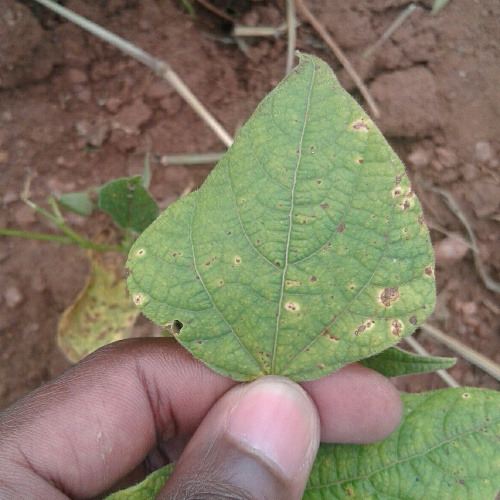

In [4]:
image = ex['image']
image

That's definitely a leaf! But what kind? 😅

Since the 'labels' feature of this dataset is a datasets.features.ClassLabel, we can use it to look up the corresponding name for this example's label ID.

First, let's access the feature definition for the 'labels'.

In [5]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

Now, let's print out the class label for our example. You can do that by using the `int2str` function of ClassLabel, which, as the name implies, allows to pass the integer representation of the class to look up the string label.

In [6]:
labels.int2str(ex['labels'])

'bean_rust'

Turns out the leaf shown above is infected with Bean Rust, a serious disease in bean plants. 😢

Let's write a function that'll display a grid of examples from each class to get a better idea of what you're working with.

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

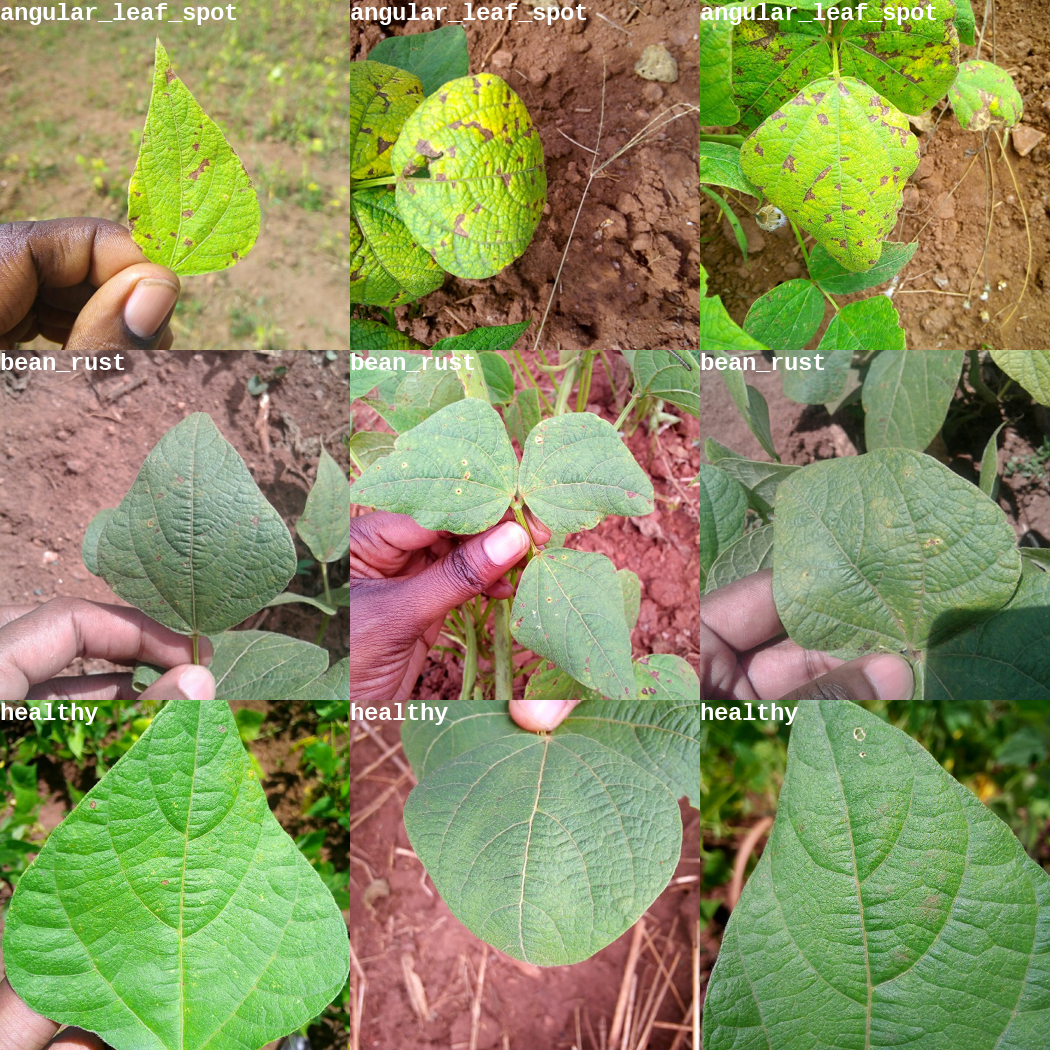

In [7]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

From what I'm seeing,

*   **Angular Leaf Spot:** Has irregular brown patches
*   **Bean Rust:** Has circular brown spots surrounded with a white-ish yellow ring
*   **Healthy:** ...looks healthy. 🤷‍♂️

## **Loading ViT Feature Extractor**

Now we know what our images look like and better understand the problem we're trying to solve. Let's see how we can prepare these images for our model!

When ViT models are trained, specific transformations are applied to images fed into them. Use the wrong transformations on your image, and the model won't understand what it's seeing! 🖼 ➡️ 🔢

To make sure we apply the correct transformations, we will use a ViTFeatureExtractor initialized with a configuration that was saved along with the pretrained model we plan to use. In our case, we'll be using the google/vit-base-patch16-224-in21k model, so let's load its feature extractor from the Hugging Face Hub (https://huggingface.co/blog/fine-tune-vit).

In [8]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
print(feature_extractor)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}



To process an image, simply pass it to the feature extractor's call function. This will return a dict containing pixel values, which is the numeric representation to be passed to the model.

You get a NumPy array by default, but if you add the return_tensors='pt' argument, you'll get back torch tensors instead.

In [9]:
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[-0.2627, -0.2627, -0.2706,  ...,  0.0902,  0.0745, -0.0039],
          [-0.2314, -0.2235, -0.2314,  ...,  0.0353,  0.0431,  0.0196],
          [-0.2471, -0.2235, -0.2235,  ...,  0.0196, -0.0118, -0.0353],
          ...,
          [ 0.2000,  0.1843,  0.1451,  ...,  0.2235,  0.2392,  0.0588],
          [ 0.2157,  0.2000,  0.1686,  ...,  0.2471,  0.1843,  0.0431],
          [ 0.2157,  0.1686,  0.2000,  ...,  0.2157,  0.0980,  0.0275]],

         [[-0.3961, -0.3961, -0.4118,  ..., -0.0745, -0.0745, -0.1451],
          [-0.3647, -0.3569, -0.3725,  ..., -0.1216, -0.0980, -0.1137],
          [-0.3882, -0.3569, -0.3569,  ..., -0.1294, -0.1451, -0.1686],
          ...,
          [ 0.0824,  0.0510, -0.0039,  ...,  0.4118,  0.2863,  0.0431],
          [ 0.0980,  0.0745,  0.0275,  ...,  0.3725,  0.1451, -0.0196],
          [ 0.0980,  0.0431,  0.0510,  ...,  0.3098,  0.0353, -0.0510]],

         [[-0.4745, -0.4745, -0.4980,  ..., -0.1608, -0.1373, -0.2078],
          [-0

## **Processing the Dataset**
Now that you know how to read images and transform them into inputs, let's write a function that will put those two things together to process a single example from the dataset.

In [10]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

process_example(ds['train'][0])

{'pixel_values': tensor([[[[ 0.0588,  0.0431,  0.0431,  ..., -0.5216, -0.5373, -0.5137],
          [ 0.1137,  0.1137,  0.0745,  ..., -0.4824, -0.5216, -0.5608],
          [ 0.0902,  0.1059,  0.0745,  ..., -0.4588, -0.4667, -0.5294],
          ...,
          [-0.2941, -0.1373,  0.0196,  ..., -0.4196, -0.4431, -0.4824],
          [ 0.0431,  0.1529,  0.1059,  ..., -0.3020, -0.2863, -0.2549],
          [ 0.2941,  0.2784,  0.1294,  ...,  0.0196,  0.1059,  0.1529]],

         [[-0.4824, -0.4824, -0.2078,  ..., -0.4275, -0.4118, -0.3804],
          [-0.4431, -0.3961, -0.1529,  ..., -0.3961, -0.4196, -0.4510],
          [-0.4667, -0.3569, -0.1216,  ..., -0.3647, -0.3882, -0.4588],
          ...,
          [-0.7020, -0.6078, -0.5137,  ..., -0.1451, -0.1608, -0.1686],
          [-0.4510, -0.3725, -0.4353,  ..., -0.1765, -0.2000, -0.1765],
          [-0.2000, -0.2314, -0.3804,  ..., -0.2314, -0.2235, -0.1922]],

         [[-0.4824, -0.4745, -0.4431,  ..., -0.7569, -0.7647, -0.7333],
          [-0

While you could call ds.map and apply this to every example at once, this can be very slow, especially if you use a larger dataset. Instead, you can apply a transform to the dataset. Transforms are only applied to examples as you index them.

First, though, you'll need to update the last function to accept a batch of data, as that's what `ds.with_transform` expects.

In [11]:
ds = load_dataset('beans')

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

  0%|          | 0/3 [00:00<?, ?it/s]

You can directly apply this to the dataset using `ds.with_transform(transform)`.

In [12]:
prepared_ds = ds.with_transform(transform)

Now, whenever you get an example from the dataset, the transform will be applied in real time (on both samples and slices, as shown below)

In [13]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[ 0.0588,  0.0431,  0.0431,  ..., -0.5216, -0.5373, -0.5137],
          [ 0.1137,  0.1137,  0.0745,  ..., -0.4824, -0.5216, -0.5608],
          [ 0.0902,  0.1059,  0.0745,  ..., -0.4588, -0.4667, -0.5294],
          ...,
          [-0.2941, -0.1373,  0.0196,  ..., -0.4196, -0.4431, -0.4824],
          [ 0.0431,  0.1529,  0.1059,  ..., -0.3020, -0.2863, -0.2549],
          [ 0.2941,  0.2784,  0.1294,  ...,  0.0196,  0.1059,  0.1529]],

         [[-0.4824, -0.4824, -0.2078,  ..., -0.4275, -0.4118, -0.3804],
          [-0.4431, -0.3961, -0.1529,  ..., -0.3961, -0.4196, -0.4510],
          [-0.4667, -0.3569, -0.1216,  ..., -0.3647, -0.3882, -0.4588],
          ...,
          [-0.7020, -0.6078, -0.5137,  ..., -0.1451, -0.1608, -0.1686],
          [-0.4510, -0.3725, -0.4353,  ..., -0.1765, -0.2000, -0.1765],
          [-0.2000, -0.2314, -0.3804,  ..., -0.2314, -0.2235, -0.1922]],

         [[-0.4824, -0.4745, -0.4431,  ..., -0.7569, -0.7647, -0.7333],
          [-0

## **Training and Evaluation**

The data is processed and you are ready to start setting up the training pipeline. This blog post uses 🤗's Trainer, but that'll require us to do a few things first:



*   **Define a collate function.**
*   **Define an evaluation metric. During training, the model should be evaluated on its prediction accuracy. You should define a compute_metrics function accordingly.**
*   **Load a pretrained checkpoint. You need to load a pretrained checkpoint and configure it correctly for training.**
*   **Define the training configuration.**

After fine-tuning the model, you will correctly evaluate it on the evaluation data and verify that it has indeed learned to correctly classify the images.



### **Define our data collator**
Batches are coming in as lists of dicts, so you can just unpack + stack those into batch tensors.

Since the collate_fn will return a batch dict, you can **unpack the inputs to the model later. ✨

In [14]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

### **Define an evaluation metric**
The accuracy metric from datasets can easily be used to compare the predictions with the labels. Below, you can see how to use it within a `compute_metrics` function that will be used by the Trainer.

In [15]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  after removing the cwd from sys.path.


Let's load the pretrained model. We'll add num_labels on init so the model creates a classification head with the right number of units. We'll also include the id2label and label2id mappings to have human-readable labels

In [16]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Almost ready to train! The last thing needed before that is to set up the training configuration by defining TrainingArguments.

Most of these are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's True because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create `'pixel_values'`.

What we are trying to say is that you'll have a bad time if you forget to set `remove_unused_columns=False`.

In [17]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

Now, all instances can be passed to Trainer and we are ready to start training!

In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


## **Train** 🚀

In [19]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1034
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 260


Step,Training Loss,Validation Loss,Accuracy
100,0.064200,0.124741,0.954887
200,0.015600,0.072924,0.977444


***** Running Evaluation *****
  Num examples = 133
  Batch size = 8
Saving model checkpoint to ./vit-base-beans/checkpoint-100
Configuration saved in ./vit-base-beans/checkpoint-100/config.json
Model weights saved in ./vit-base-beans/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./vit-base-beans/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 133
  Batch size = 8
Saving model checkpoint to ./vit-base-beans/checkpoint-200
Configuration saved in ./vit-base-beans/checkpoint-200/config.json
Model weights saved in ./vit-base-beans/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./vit-base-beans/checkpoint-200/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./vit-base-beans/checkpoint-200 (score: 0.07292386144399643).
Saving model checkpoint to ./vit-base-beans
Configuration saved in ./vit-base-beans/config.json
Model weights saved in ./vit

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1221
  train_runtime            =  0:02:10.55
  train_samples_per_second =       31.68
  train_steps_per_second   =       1.991


## **Evaluate** 📊

In [20]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 133
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9774
  eval_loss               =     0.0729
  eval_runtime            = 0:00:02.81
  eval_samples_per_second =     47.289
  eval_steps_per_second   =      6.044


Here were my evaluation results - Cool beans!😎